# Cleaning / Preprocessing / EDA Notebook

This data comes from a pipeline created here: [PhilAuditSystem](https://github.com/jackvaughan09/PhilippinesAuditSystem)

- **Audit observation**: The reported finding from the audit
- **Recommendation**: The recommendation from the audit committee to the audited entity
- **Status of Implementation**: Whether the recommendation was implemented or not
- **Reasons for partial/non-implementation**: If the recommendation was not implemented, the reason why
- **Management Action**: The action taken by the audited entity to address the recommendation
- **References**: The reference to the law or regulation that the recommendation is based on
- **Source**: The source of the audit report



Throughout the notebook, there will be commented code for saving out certain slices of the dataframe to csv. These slices will be stored with relevant names in the `data/exploration` folder.

Much of the analysis done at certain points relied heavily upon being able to open up a spreadsheet and do some manual searching. Fortunately, the dataset is not so large as to make this overly cumbersome. 

The notebook is entirely understandable without doing the searching yourself, but the data is there for convenience.

### Importing Libraries

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

## Reading in Data

In [105]:
# Set the working directory
wd = '../data/source_data'

In [106]:
dfs = [] # List of DataFrames
for file in os.listdir(wd):
    if file.endswith('.xlsx'):
        df = pd.read_excel(os.path.join(wd, file), index_col=0)
        dfs.append(df.applymap(lambda x: x.lower() if isinstance(x, str) else x))
df = pd.concat(dfs, axis=0)
df = df.reset_index(drop=True)
print(df.shape)


(4881, 7)


In [107]:
df.columns =(
    df.columns
    .str.replace(' ', '_')
    .str.lower()
    .str.replace('/', '_or_')
    .str.replace('-', '_')
)
df.columns

Index(['audit_observation', 'recommendations', 'status_of_implementation',
       'reasons_for_partial_or_non_implementation', 'management_action',
       'references', 'source'],
      dtype='object')

### Duplicated Values --> Drop

In [108]:
len(df.loc[df.duplicated()])

124

In [109]:
print(df.shape)
df.drop_duplicates(keep="first", inplace=True)
print(df.shape)
df.reset_index(drop=True, inplace=True)

(4881, 7)
(4757, 7)


___

## Missing Values

We have a lot of missing values, but for the most part, this won't be an issue. Later on, some of these features will be combined. So, let's first take care of the rows where it is all or almost entirely missing -- we'll drop those.

In [110]:
df.isna().sum()

audit_observation                             239
recommendations                              1653
status_of_implementation                      677
reasons_for_partial_or_non_implementation     798
management_action                             877
references                                    330
source                                          0
dtype: int64

In [111]:
# If a row only has values in its references or source columns,
# then we can drop that sucker. 
only_references = df.loc[
    (df.audit_observation.isna()) &
    (df.recommendations.isna()) &
    (df.status_of_implementation.isna()) &
    (df.reasons_for_partial_or_non_implementation.isna())&
    ((df.references.notna()) | (df.source.notna()))
]
print(only_references.shape)
only_references.head()

(21, 7)


,audit_observation,recommendations,status_of_implementation,reasons_for_partial_or_non_implementation,management_action,references,source
713,NaN,NaN,NaN,NaN,NaN,2012,01-nuevaera2013_audit_report.pdf
723,NaN,NaN,NaN,NaN,NaN,2011,01-nuevaera2013_audit_report.pdf
728,NaN,NaN,NaN,NaN,NaN,2010,01-nuevaera2013_audit_report.pdf
733,NaN,NaN,NaN,NaN,NaN,2009,01-nuevaera2013_audit_report.pdf
736,NaN,NaN,NaN,NaN,NaN,2008,01-nuevaera2013_audit_report.pdf


In [112]:
only_references.to_csv('../data/exploration/only_references.csv')

In [113]:
df.drop(only_references.index, inplace=True)
df = df.reset_index(drop=True)
df.shape

(4736, 7)

___

## Empty Observation Analysis

Most important for the text analysis is the `audit observation` column. We'll take a look into the missing values in that column, specifically, to see what the best way to clean and preserve data is.

In [114]:
# All columns except source --> has no missing values
empty_observations = df.loc[df['audit_observation'].isna(), df.columns[:-1]] 

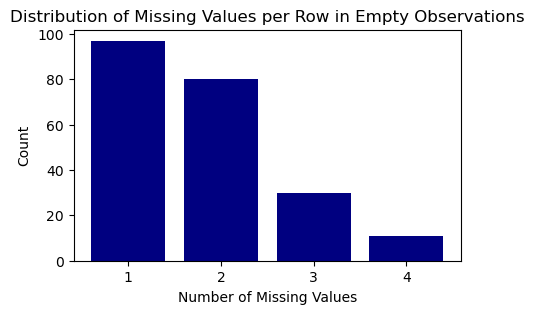

In [115]:
# of the empty observations, what is the distribution of the total missing values per row?
plt.figure(figsize=(5, 3))
plt.bar(
    x = range(1,5),
    height=empty_observations.isna().sum(axis=1).value_counts().sort_index(),
    color='navy'
)
plt.title('Distribution of Missing Values per Row in Empty Observations')
plt.xticks(range(1,5))
plt.xlabel('Number of Missing Values')
plt.ylabel('Count');

In [116]:
# of the empty observations, how many missing values are in each column?
empty_observations.isna().sum(axis=0).sort_values(ascending=False)

audit_observation                            218
status_of_implementation                      70
reasons_for_partial_or_non_implementation     47
management_action                             33
references                                    14
recommendations                                9
dtype: int64

##### Let's take a look into those missing values:

In [117]:
few_missings = empty_observations.loc[
    (empty_observations.isna().sum(axis=1) > 0) &
    (empty_observations.isna().sum(axis=1) <= 2)
].index.tolist()
df.loc[few_missings].head()

,audit_observation,recommendations,status_of_implementation,reasons_for_partial_or_non_implementation,management_action,references,source
69,NaN,1. collections were not deposited intact with ...,n/a n/a,partially implemented. balances however as of ...,reconciliation between records of the accounti...,aar 2012,01-sual2013_audit_report.pdf
70,NaN,2. adjusting or correcting entries to take up ...,n/a n/a,partially implemented.,recorded as receivables the bank charges incur...,aar 2012,01-sual2013_audit_report.pdf
71,NaN,"3. cash advances totalling p3,494,355.52 were ...",n/a n/a,partially implemented. the non-granting of cas...,no additional cash advances were granted to of...,aar 2012,01-sual2013_audit_report.pdf
72,NaN,"4. receivables totalling p577,426,807.92 were ...",NaN,unimplemented.,requested the staff of the municipal administr...,aar 2012,01-sual2013_audit_report.pdf
73,NaN,"5. property, plant and equipment account balan...",n/a n/a,unimplemented.,accounting office maintain ppe ledger card for...,aar 2012,01-sual2013_audit_report.pdf


In [118]:
df.loc[few_missings].to_csv('../data/exploration/few_missings.csv')

In [119]:
more_missings = empty_observations.loc[
    (empty_observations.isna().sum(axis=1) > 2) &
    (empty_observations.isna().sum(axis=1) <= 4)
].index.tolist()
df.loc[more_missings].head()

,audit_observation,recommendations,status_of_implementation,reasons_for_partial_or_non_implementation,management_action,references,source
486,NaN,4. the reliability and accuracy of the cash in...,NaN,not implemented the acting accountant failed t...,NaN,2012 aar p. 18-19,05-mahatao2013_part3-status_of_py's_recommenda...
685,NaN,1. various reconciling items in the bank recon...,NaN,NaN,partially implemented,2012 aar,11-mayantoc2013_part3-status_of_py's_recommend...
687,NaN,"3. recorded receivables amounting to p49,404.0...",NaN,NaN,partially implemented,2012 aar,11-mayantoc2013_part3-status_of_py's_recommend...
689,NaN,"5. the reported property, plant and equipment ...",NaN,NaN,partially implemented,2012 aar,11-mayantoc2013_part3-status_of_py's_recommend...
690,NaN,"6. due to inadequate planning, development fun...",NaN,NaN,partially implemented,2012 aar,11-mayantoc2013_part3-status_of_py's_recommend...


In [120]:
df.loc[more_missings].to_csv('../data/exploration/more_missings.csv')

##### Analysis:

- Though the tables displayed may not have much variance due to the `.head()` method, there is quite a lot different between each individual source's missing values.
- Sometimes, the filled values for a row missing the observation look like overflow.
- Other times, these filled values, specifically in the `recommendations` column, look like they are the actual values for the audit observation.

##### Solution:
> Continue to investigate before making a decision on keeping, dropping, or conducting overflow repair on the missing values.

___

### Empty observations with no recommendations

> We'll drop these rows!

In [121]:
# initialize a list to store the indices of the rows to drop
to_drop = []

empty_observations.loc[
    (empty_observations.recommendations.isna())
]

,audit_observation,recommendations,status_of_implementation,reasons_for_partial_or_non_implementation,management_action,references
1236,NaN,NaN,not implemented,the lgu replied that expenses for cultural act...,.,NaN
1237,NaN,NaN,not implemented,lgu had started the conduct of actual physical...,NaN,NaN
2258,NaN,NaN,"265,716.00","6,461,847.33","6,727,563.33",mooe
2263,NaN,NaN,"1,162,441.05",4,"432,000.00",01/06/14
2264,NaN,NaN,"268,246.33",5,"894,194.72",01/07/14
2265,NaN,NaN,15.08,6,"268,231.25",01/08/14
2266,NaN,NaN,-,8,15.08,01/10/14
2269,NaN,NaN,"454,487.06",4,"600,000.00",01/06/14
3252,NaN,NaN,imple- mentation,non- implementation,NaN,NaN


In [122]:
empty_observations.loc[
    (empty_observations.status_of_implementation.isna())
].to_csv('../data/exploration/empty_observations_no_recommendations.csv')

In [123]:
to_drop.extend(empty_observations.loc[empty_observations.recommendations.isna()].index)

___

### Empty observations with no references

> These appear to be overflow rows!

In [124]:
needs_repair = []
no_references = empty_observations.loc[
    (empty_observations.references.isna())
]
print(no_references.shape)
no_references.head()

(14, 6)


,audit_observation,recommendations,status_of_implementation,reasons_for_partial_or_non_implementation,management_action,references
1236,NaN,NaN,not implemented,the lgu replied that expenses for cultural act...,.,NaN
1237,NaN,NaN,not implemented,lgu had started the conduct of actual physical...,NaN,NaN
1245,NaN,infrastructure projects we recommended strict,implemente,NaN,NaN,NaN
1283,NaN,the head of the market economic enterprise is ...,not implemente d,management is now in the process of preparing ...,NaN,NaN
2230,NaN,1. the balance of cash in bank reflected the f...,NaN,implemented implemented,reconciliation was made and adjustments were e...,NaN


In [125]:
no_references.to_csv('../data/exploration/no_references.csv')

In [126]:
needs_repair.extend(no_references.index)

##### We won't drop `to_drop` or fix the `needs_repair` indicies until later on!

___

### Empty observations with no status of implementation

> Looks like the status of implementation is contained in the reasons for partial/non-implementation column!

We'll push the `reasons for partial/non-implementation` column into the `status of implementation` column, and then drop the former.

In [127]:
here_be_status = (empty_observations.loc[
                 (empty_observations.status_of_implementation.isna())
                 ].reasons_for_partial_or_non_implementation
                 .value_counts())
print(f"There are {here_be_status.shape[0]} unique reasons for partial or non-implementation for empty observations.")
print("Here are the top ten:")
here_be_status[0:10]

There are 29 unique reasons for partial or non-implementation for empty observations.
Here are the top ten:


implemented.                                                                                   6
not implemented.                                                                               5
implemented                                                                                    3
unimplemented.                                                                                 2
partially implemented                                                                          2
partially implemented.                                                                         2
fully implemented.                                                                             2
no explanation from the manageme nt and reply to our manageme nt letter dated oct. 15, 2012    2
not implemented                                                                                2
partially implemented no report yet was submitted in this office for validation                1
Name: reasons_for_partial_or_n

In [128]:
here_be_status.to_csv('../data/exploration/empty_observations_no_status.csv')

In [129]:
# Snag the indicies 
stray_status_data = empty_observations.loc[
    (empty_observations.status_of_implementation.isna())
].index.tolist()

# Push reasons_for_partial_or_non_implementation into status_of_implementation
# @ those indicies
df.loc[stray_status_data, 'status_of_implementation'] \
    = df.loc[stray_status_data, 'reasons_for_partial_or_non_implementation']

# Set reasons_for_partial_or_non_implementation to NaN
df.loc[stray_status_data, 'reasons_for_partial_or_non_implementation'] = np.nan
print(df.loc[stray_status_data].shape)
df.loc[stray_status_data].head()


(70, 7)


,audit_observation,recommendations,status_of_implementation,reasons_for_partial_or_non_implementation,management_action,references,source
72,NaN,"4. receivables totalling p577,426,807.92 were ...",unimplemented.,NaN,requested the staff of the municipal administr...,aar 2012,01-sual2013_audit_report.pdf
74,NaN,6. fund transfer to non- governmental organiza...,partially implemented,NaN,submitted some of the documents needed.,aar 2012,01-sual2013_audit_report.pdf
75,NaN,7. payment of infrastructure projects,partially,NaN,according to bac,aar,01-sual2013_audit_report.pdf
76,NaN,"totalling p27,879,640.77 were not supported wi...",implemented,NaN,chairman they already complied and submitted s...,2012,01-sual2013_audit_report.pdf
78,NaN,9. the gender and development plan and accompl...,unimplemented.,NaN,not yet submitted for review.,aar 2012,01-sual2013_audit_report.pdf


Nice.

___

### Missing observations with recommendations

In [130]:
no_obs_but_has_rec = empty_observations.loc[
    (empty_observations.recommendations.notna())
].index.tolist()
print(df.loc[no_obs_but_has_rec].shape)
df.loc[no_obs_but_has_rec].head()


(209, 7)


,audit_observation,recommendations,status_of_implementation,reasons_for_partial_or_non_implementation,management_action,references,source
69,NaN,1. collections were not deposited intact with ...,n/a n/a,partially implemented. balances however as of ...,reconciliation between records of the accounti...,aar 2012,01-sual2013_audit_report.pdf
70,NaN,2. adjusting or correcting entries to take up ...,n/a n/a,partially implemented.,recorded as receivables the bank charges incur...,aar 2012,01-sual2013_audit_report.pdf
71,NaN,"3. cash advances totalling p3,494,355.52 were ...",n/a n/a,partially implemented. the non-granting of cas...,no additional cash advances were granted to of...,aar 2012,01-sual2013_audit_report.pdf
72,NaN,"4. receivables totalling p577,426,807.92 were ...",unimplemented.,NaN,requested the staff of the municipal administr...,aar 2012,01-sual2013_audit_report.pdf
73,NaN,"5. property, plant and equipment account balan...",n/a n/a,unimplemented.,accounting office maintain ppe ledger card for...,aar 2012,01-sual2013_audit_report.pdf


> We'll take these recommendations and push them into the observation space. We'll also fill the recommendations with NaNs.

The reason for this approach is not only that some audit observations were mistakenly put into the recommendations column, but also that we will eventually take this approach for the entire dataset. That is to say, before analysis, we'll squish the `recommendations` and `audit observations` into one column, and then drop the recommendations column. We'll do the same for `reasons for partial/non-implementation` and `status of implementation`.

In [131]:
df.loc[no_obs_but_has_rec].to_csv('../data/exploration/no_obs_but_has_rec.csv')

In [132]:
df.loc[no_obs_but_has_rec, 'audit_observation'] = \
    df.loc[no_obs_but_has_rec, 'recommendations']
    
df.loc[no_obs_but_has_rec, 'recommendations'] = np.nan
df.loc[no_obs_but_has_rec].head()

,audit_observation,recommendations,status_of_implementation,reasons_for_partial_or_non_implementation,management_action,references,source
69,1. collections were not deposited intact with ...,NaN,n/a n/a,partially implemented. balances however as of ...,reconciliation between records of the accounti...,aar 2012,01-sual2013_audit_report.pdf
70,2. adjusting or correcting entries to take up ...,NaN,n/a n/a,partially implemented.,recorded as receivables the bank charges incur...,aar 2012,01-sual2013_audit_report.pdf
71,"3. cash advances totalling p3,494,355.52 were ...",NaN,n/a n/a,partially implemented. the non-granting of cas...,no additional cash advances were granted to of...,aar 2012,01-sual2013_audit_report.pdf
72,"4. receivables totalling p577,426,807.92 were ...",NaN,unimplemented.,NaN,requested the staff of the municipal administr...,aar 2012,01-sual2013_audit_report.pdf
73,"5. property, plant and equipment account balan...",NaN,n/a n/a,unimplemented.,accounting office maintain ppe ledger card for...,aar 2012,01-sual2013_audit_report.pdf


##### One last check on our audit observations:

In [133]:
df.isna().sum()

audit_observation                               9
recommendations                              1841
status_of_implementation                      610
reasons_for_partial_or_non_implementation     823
management_action                             856
references                                    329
source                                          0
dtype: int64

In [134]:
# confirming that we have the right indicies to drop
df.loc[df.audit_observation.isna()].index.tolist() == to_drop

True

In [135]:
# If there is any overlap between the two lists, then to_drop will take precedence.
# We risk interfering with other data if we repair unnecessarily. 
intersect = set.intersection(set(to_drop), set(needs_repair))
if intersect:
    needs_repair = list(set(needs_repair) - set(to_drop))
    print(f"There were {len(intersect)} overlapping indicies between to_drop and needs_repair.")
else:
    print("Good to go!")

There were 3 overlapping indicies between to_drop and needs_repair.


Now that we have all of this done, we'll create our overflow repair function and apply it to the `needs_repair` indicies.
Then we can drop both the `to_drop` and `needs_repair` indicies and tidy up the dataframe.

___

## Overflow Correction

Due to the nature of the corpus, there are a lot of instances where the text is cut off between pages or floating between rows. This is due to the fact that the text comes from **EXTREMELY** poorly formatted pdf tables. The computer vision PDF scraping library, [camelot](https://pypi.org/project/camelot-py/), that was used in the data pipeline is not able to handle these tables, so we have to manually correct the data from them.


Examples:

!["What is going on"](../img/pdf/datadisarray.png)

!["What are columns?"](../img/pdf/whatarecolumns.png)

!["Uhhhh...](../img/pdf/uhhhhh.png)


### Overflow Correction Function

- Source column makes it difficult/annoying to concatinate the overflow back to the original without duplicating the value. 

In [136]:
# Join the rows with overflowed data back to the previous row
def overflow_repair(df: pd.DataFrame, ovfl_ind: list):
    for i in ovfl_ind:
        if i == 0: # Skip the first row, can't be overflow
            continue
        cols = df.columns.tolist()
        cols.remove('source') # Exclude source column
        try:
            df.loc[i - 1, cols] += " " + df.loc[i, cols]
        except:
            raise f"Error at index {i}"
    return df

In [137]:
df = overflow_repair(df, needs_repair)

> Time to deal with `needs_repair` and `to_drop`!

In [138]:
print(df.shape)
df = df.drop(index=needs_repair)
df = df.drop(index=to_drop)
df = df.reset_index(drop=True)
df.shape

(4736, 7)


(4716, 7)

___

## Regex-Based Overflow Repair 
In order to ensure that each row is a single observation, we'll need to do some regex parsing of the string data. I've noticed a pattern, that is, that each distinct observation comes numbered with something like " 1. " or " 2) " etc. We can use this pattern to detect overflow. 

However, I've found that this is only relevant when a particular source has numbers for some observations and not for others. Some sources have no numberings for any observations, and some have numberings for all observations. 


Example:

| Audit Observation | Source |
| --- | --- |
| 1. Hello World! | 1 |
| 2. Hello World! | 1 |
| 3. Hello World! | 1 |
| 1. Hello W | 2 |
| orld!. | 2 |
| 2. Hello World! | 2 |
| Hello World! | 3 |
| Hello World! | 3 |
| Hello World! | 3 |


In [139]:
import re

def is_distinct_audit(string):
    """
    Something consistent in the audit observation column is that overflow rows do 
    not contain a numbered 'index' e.g. 1. or 2)  etc. in the first 20 or so
    characters in the string. This function checks for that pattern and returns True
    if it is found.
    
    Note: This is not a perfect solution, as some of the observations do not follow
    this pattern. However, it better than nothing.
    
    Parameters
    ----------
    string : str
        The string to check for the pattern.
    
    Returns
    -------
    bool : True if the pattern is found, False otherwise.
    """
    string = str(string)[:20]
    regex = r'(\d+\.)|(\)\s)|(\s\d+\s)|(\d+\s+)'
    matches = re.findall(regex, string)
    return bool(matches)

In [140]:
# For each source:
# ---------------------------
# If there are  a n y  distinct observations, AND there are [more than 2]
# distinct observations identified through the regex parsing, then there 
# are overflow rows in that source. We'll grab the indicies of the
# overflow rows and add them to a list.
count = 0
original_indicies_of_overflow = []
for source in df.source.unique():
    frame = df.loc[df.source == source, 'audit_observation']
    distinct = frame.apply(is_distinct_audit).sum()
    if (distinct > 2 and distinct != len(frame)): 
        indicies = frame.loc[
            frame.apply(is_distinct_audit) == False
        ].index.tolist()
        count += len(indicies)
        original_indicies_of_overflow.extend(indicies)

print(count)
print(original_indicies_of_overflow)

364
[32, 36, 40, 42, 45, 46, 47, 48, 55, 76, 102, 112, 121, 150, 201, 202, 203, 204, 476, 489, 522, 564, 566, 568, 570, 572, 574, 575, 577, 579, 581, 582, 585, 598, 620, 686, 688, 692, 694, 742, 763, 828, 887, 888, 889, 891, 892, 893, 894, 895, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 978, 981, 983, 985, 988, 1034, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1066, 1105, 1113, 1116, 1126, 1146, 1149, 1152, 1154, 1156, 1284, 1287, 1288, 1289, 1295, 1326, 1327, 1350, 1401, 1403, 1405, 1406, 1419, 1420, 1422, 1424, 1425, 1427, 1433, 1508, 1509, 1512, 1535, 1537, 1573, 1619, 1646, 1719, 1725, 1727, 1729, 1731, 1734, 1738, 1740, 1741, 1744, 1791, 1826, 1852, 1856, 1858, 1859, 1868, 1869, 1870, 1901, 1938, 1939, 1941, 1943, 1945, 1946, 1948, 1950, 1956, 1966, 2006, 2007, 2009, 2010, 2046, 2209, 2216, 2218, 2225, 2233, 2252, 2253, 2254, 2255, 2256, 2258, 2259, 2305, 2325, 2326, 2327, 2385, 2436, 2440, 2488, 2492, 2523, 2562, 2584, 2589, 2596, 2631, 2632, 2634, 264

In [141]:
df = overflow_repair(df, original_indicies_of_overflow)
print(df.shape)
df = df.drop(index=original_indicies_of_overflow)
df = df.reset_index(drop=True)
df.shape

(4716, 7)


(4352, 7)

> It can be discouraging to see that sample size decrease over time, but it'll be worth it when the data is squeaky clean!

___

## Creating Conglomerated Text Features:

In at least half of the cases in which the audit observation is empty and the recommendation is filled, the recommendation column contains details about the audit observation. Sometimes those "recommendations" are the actual audit observation that's gone astray. In any case, we are going to combine these features for all observations. 

We'll be calculating the word embeddings (more on that later) in the unsupervised learning portion of this analysis. By combining the two text features, I believe that we'll end up providing valuable information about the status of implementation (target) to our word embedding transformer that will hopefully bolster our results.

In [142]:
df.audit_observation += " " + df.recommendations.fillna('')
df.drop(columns=['recommendations'], inplace=True)

In [143]:
df.head()

,audit_observation,status_of_implementation,reasons_for_partial_or_non_implementation,management_action,references,source
0,9. payments of honoraria to bids and awards co...,fully implemented,NaN,all taxes due have been deducted from honorari...,NaN,09-taysan2013_part3-status_of_py's_recommendat...
1,"1. the cash in bank – local currency, current ...",fully implemented,NaN,the municipal accountant was already instructe...,aar 2012,12-valencia2013_status_of_py's_recommendation.pdf
2,2. collectors failed to remit their collection...,partially implemented,there are still instances wherein collectors f...,a memorandum on the matter was already issued ...,aar 2012,12-valencia2013_status_of_py's_recommendation.pdf
3,3. the collections remitted to the municipal t...,partially implemented,,a memorandum on the matter was already issued ...,aar 2012,12-valencia2013_status_of_py's_recommendation.pdf
4,"4. existence, validity and correctness of the ...",partially implemented,the plan of conducting the physical count of p...,this office has already constituted an invento...,aar 2012,12-valencia2013_status_of_py's_recommendation.pdf


In [144]:
df.audit_observation.isna().sum()

0

> Great! Now our `audit observation` column is good to go.

___

## The Status of Implementation Column

In further analysis, the `status of implementation` column will be used as the target feature. Since there are so many missings here, we'll need to do some investigation and cleaning to ascertain the true status of implementation for each observation. We'll go through this column in much the same way as we went through the `audit_observation` column -- assessing the overlap between missing values and the other columns.

In [145]:
df.status_of_implementation.isna().sum()

532

### Empty status of implementation with no recommendations

In [146]:
no_status_no_reason = df.loc[
    (df.status_of_implementation.isna()) & 
    (df.reasons_for_partial_or_non_implementation.isna())
]
print(no_status_no_reason.shape)
no_status_no_reason.head()

(71, 6)


,audit_observation,status_of_implementation,reasons_for_partial_or_non_implementation,management_action,references,source
527,this finding is reiterated in part ii of this ...,NaN,NaN,not implemented partially implemented,cy 2012 aar cy 2012 aar,11-moncada2013_part3-status_of_py's_recommenda...
650,1. various reconciling items in the bank recon...,NaN,NaN,partially implemented partially implemented,2012 aar 2012 aar,11-mayantoc2013_part3-status_of_py's_recommend...
651,"3. recorded receivables amounting to p49,404.0...",NaN,NaN,partially implemented not implemented,2012 aar 2012 aar,11-mayantoc2013_part3-status_of_py's_recommend...
652,"5. the reported property, plant and equipment ...",NaN,NaN,partially implemented,2012 aar,11-mayantoc2013_part3-status_of_py's_recommend...
653,"6. due to inadequate planning, development fun...",NaN,NaN,partially implemented,2012 aar,11-mayantoc2013_part3-status_of_py's_recommend...


> Interesting. After browsing the data in a spreadsheet viewer, I confirmed that some of the `management actions` are actually the `status of implementation`. It occurs *specifically* (only) when there is data in the `references` column as well!

In [147]:
no_status_no_reason.to_csv('../data/exploration/no_status_no_reason_with_recs.csv')

In [148]:
# Save the indicies of stray statuses
status_roundup = df.loc[
    (df.status_of_implementation.isna()) &
    (df.reasons_for_partial_or_non_implementation.isna()) &
    (df.references.notna())
].index.tolist()

In [149]:
# round 'em up and put 'em where they belong
df.loc[status_roundup, 'status_of_implementation'] = \
    df.loc[status_roundup, 'management_action']
df.loc[status_roundup, 'management_action'] = np.nan
df.loc[status_roundup].head()

,audit_observation,status_of_implementation,reasons_for_partial_or_non_implementation,management_action,references,source
527,this finding is reiterated in part ii of this ...,not implemented partially implemented,NaN,NaN,cy 2012 aar cy 2012 aar,11-moncada2013_part3-status_of_py's_recommenda...
650,1. various reconciling items in the bank recon...,partially implemented partially implemented,NaN,NaN,2012 aar 2012 aar,11-mayantoc2013_part3-status_of_py's_recommend...
651,"3. recorded receivables amounting to p49,404.0...",partially implemented not implemented,NaN,NaN,2012 aar 2012 aar,11-mayantoc2013_part3-status_of_py's_recommend...
652,"5. the reported property, plant and equipment ...",partially implemented,NaN,NaN,2012 aar,11-mayantoc2013_part3-status_of_py's_recommend...
653,"6. due to inadequate planning, development fun...",partially implemented,NaN,NaN,2012 aar,11-mayantoc2013_part3-status_of_py's_recommend...


___

### No Status, with Reasons? (Missing statuses pt.2)

> In the vast majority of cases, the reasons for partial or non-implementation contain an indication of the status of implementation. Though this isn't a perfect solution, we'll take a slight shortcut by sliding the those `reasons` over to the missing status column entries.

In [150]:
print(df.loc[df.status_of_implementation.isna()].shape)
df.loc[df.status_of_implementation.isna()].head()

(490, 6)


,audit_observation,status_of_implementation,reasons_for_partial_or_non_implementation,management_action,references,source
17,7. long overdue uncollected receivables from r...,NaN,recommendation was not implemented. records an...,the account remained dormant during the past 2...,aar cy 2011,05-solana2013_part3-status_of_implementations_...
18,8. collection from various accounts in the amo...,NaN,recommendation was implemented early jan. 2013.,year-end collections were not deposited before...,aar cy 2012,05-solana2013_part3-status_of_implementations_...
20,"10. disallowances amounting to p560,348.36 rem...",NaN,recommendation was partially implemented. this...,"there was a settlement of p73,248.36.",aar cy 2012,05-solana2013_part3-status_of_implementations_...
21,11. the newly constructed market totaling to p...,NaN,recommendation was partially implemented. this...,not acted upon during the year.,aar cy 2012,05-solana2013_part3-status_of_implementations_...
49,11. remittance of taxes withheld are sometimes...,NaN,fully implemented.,management has been vigilant in the remittance...,cy 2012 aar,05-solano2013_part3-status_of_pys_audit_recomm...


In [151]:
df.loc[df.status_of_implementation.isna()].to_csv('../data/exploration/no_status_with_reasons.csv')

In [152]:
df.loc[df.status_of_implementation.isna(), 'status_of_implementation'] = \
    " " + df.reasons_for_partial_or_non_implementation.fillna('')
df.drop(columns=['reasons_for_partial_or_non_implementation'], inplace=True)

In [153]:
df.status_of_implementation.isna().sum()

0

### Nice! We are all done with moving the data around :)

___

## String Cleaning!

Something persistent in the `status of implementation` column is the presence of spaces disturbing the status variable. E.g. "Implemented" & "Implemen ted". This issue runs deep and affects all of our status variables. We'll need to devise a method of overcoming it. There are also many instances of the string "N/A" in the `status` column we'll need to fix.

> We'll deal with the N/A's first.

#### "N/A" Cleaning

We only care about instances where the status only has "N/A"s and doesn't contain the word 'Implemented'. Sometimes the N/A was moved up in overflow repair.
We'll set those to `not implemented`.

In [154]:
status_na_strings = df.loc[
    (df.status_of_implementation.str.contains('implemented') == False) &
    (df.status_of_implementation.str.contains('n/a'))
]
print(status_na_strings.shape)
status_na_strings.head()

(309, 5)


,audit_observation,status_of_implementation,management_action,references,source
16,"1. ms. regilyn c. pamittan, revenue collection...",n/a n/a,none during the year 2013. the municipal faile...,aar cy 2012 aar cy 2012,05-solana2013_part3-status_of_implementations_...
19,"9. out of the total receivables of p2,627,868....",n/a n/a,"the account remained dormant.during the year, ...",aar cy 2012,05-solana2013_part3-status_of_implementations_...
55,"6.the amount of p7,880,491.05 in cash advances...",n/a n/a,the accounting & treasury offices have monitor...,cy 2012 aar,05-solano2013_part3-status_of_pys_audit_recomm...
59,"10. the balance of p43,966,006.27 of loans pay...",n/a n/a,the accounting office has prepared a reconcili...,cy 2012 aar,05-solano2013_part3-status_of_pys_audit_recomm...
60,1. collections were not deposited intact with ...,n/a n/a,reconciliation between records of the accounti...,aar 2012,01-sual2013_audit_report.pdf


In [155]:
na_string_indicies = status_na_strings.index.tolist()
df.status_of_implementation.loc[na_string_indicies] = "not implemented"
df.loc[na_string_indicies].head()

,audit_observation,status_of_implementation,management_action,references,source
16,"1. ms. regilyn c. pamittan, revenue collection...",not implemented,none during the year 2013. the municipal faile...,aar cy 2012 aar cy 2012,05-solana2013_part3-status_of_implementations_...
19,"9. out of the total receivables of p2,627,868....",not implemented,"the account remained dormant.during the year, ...",aar cy 2012,05-solana2013_part3-status_of_implementations_...
55,"6.the amount of p7,880,491.05 in cash advances...",not implemented,the accounting & treasury offices have monitor...,cy 2012 aar,05-solano2013_part3-status_of_pys_audit_recomm...
59,"10. the balance of p43,966,006.27 of loans pay...",not implemented,the accounting office has prepared a reconcili...,cy 2012 aar,05-solano2013_part3-status_of_pys_audit_recomm...
60,1. collections were not deposited intact with ...,not implemented,reconciliation between records of the accounti...,aar 2012,01-sual2013_audit_report.pdf


In [156]:
df.isna().sum()

audit_observation             0
status_of_implementation      0
management_action           832
references                  249
source                        0
dtype: int64

> Nice!
___

## Fuzzy Matching

Returning to the talk of stray spaces and punctuation in the `status of implementation` column, we'll need to do some *fuzzy matching* to ensure that we have a consistent set of status values.
This will be a long section:

In [157]:
df.status_of_implementation.value_counts()[0:10]

not implemented            708
partially implemented      514
partially implemented      423
not implemented            411
fully implemented          197
implemented                184
implemented                176
fully implemented          171
partially implemented.      57
not implemented.            45
Name: status_of_implementation, dtype: int64

> We can see that there is some small variance in the statuses of implementation such that 'not implemented' and 'not implemented  ' are different. We want statuses that are similar to be mapped to the same value.

 We'll use some fuzzy logic from the [fuzzywuzzy](https://pypi.org/project/fuzzywuzzy/) library to do this.

In [158]:
from fuzzywuzzy import process as fuzz_process

def find_fuzzy_matches(df: pd.DataFrame, col: str, match: str, threshold: int = 96):
    """
    This function uses fuzzywuzzy to find matches in a column of a dataframe.
    You can specify a threshold for the score of the matches to tune the results.
    Args:
        df (pd.DataFrame): df
        col (str): column to search
        match (str): what to match
        threshold (int, optional): score threshold for matches. Defaults to 96.

    Returns:
        list: list of matches
    """

    matches = fuzz_process.extract(match, df.status_of_implementation, limit=None)
    return list(set(i[0].strip() for i in matches if i[1] >= threshold))

> Throughout this section, the threshold values in `find_fuzzy_matches()` are not arbitrary. They are the result of a lot of trial and error. I've found that the threshold values that work best for this dataset are 92-95. We'll have to do some manual cleaning of the match values for each attempt, but it's worth it in the end.

___

#### Matching 'Implemented'

In [159]:
# Demonstration:
matches = find_fuzzy_matches(
    df, 
    'status_of_implementation',
    'implemented',
    92)
matches = list(set(
    match.replace('not ', '')
    for match in matches
    ))
matches

['implemente d',
 'unimplemented.',
 'implemented .',
 'unimplemented',
 'implemen ted',
 'impleme nted',
 'implemented',
 'implement ed',
 'implemen- ted',
 'implemented.',
 'imple mented']

In [160]:
# This is that manual cleaning I mentioned earlier.
# replace 'unimplemented' with 'not implemented',
# remove 'unimplemented' from matches
df.status_of_implementation = df.status_of_implementation.apply(
    lambda x:
        str(x).replace('unimplemented', 'not implemented')
        .replace('unimplemented.', 'not implemented')
)
matches.remove('unimplemented')
matches.remove('unimplemented.')
matches

['implemente d',
 'implemented .',
 'implemen ted',
 'impleme nted',
 'implemented',
 'implement ed',
 'implemen- ted',
 'implemented.',
 'imple mented']

In [161]:
for match in matches:
    df.status_of_implementation = \
        df.status_of_implementation.apply(
            lambda x: x.replace(match, 'implemented') 
        )
df.status_of_implementation = df.status_of_implementation.str.strip()
df.status_of_implementation.value_counts()[0:10]

not implemented                                1285
partially implemented                          1172
implemented                                     489
fully implemented                               482
partially implemented partially implemented      32
                                                 29
not implemented not implemented                  21
not implemented partially implemented            19
partially implemented not implemented            18
status of implement- ation                       13
Name: status_of_implementation, dtype: int64

___
#### Matching 'Not Implemented'

In [162]:
matches = find_fuzzy_matches(df, 'status_of_implementation', 'not implemented', threshold=92)
matches

['not implemented the',
 'not implem ented',
 'not implemented not',
 'not imple mente d',
 'not implemente',
 'implemented',
 'not yet implemented',
 'not implemented']

In [163]:
matches.remove('implemented')
matches.remove('not implemented not')
matches.remove('not implemented the')
for match in matches:
    df.status_of_implementation = \
        df.status_of_implementation.apply(
            lambda x: x.replace(match, 'not implemented') 
            .replace('implementedd', 'implemented') # fix a typo
        )
df.status_of_implementation.value_counts()[0:10]

not implemented                                1300
partially implemented                          1172
implemented                                     489
fully implemented                               482
partially implemented partially implemented      32
                                                 29
not implemented not implemented                  21
partially implemented not implemented            19
not implemented partially implemented            19
status of implement- ation                       13
Name: status_of_implementation, dtype: int64

___

#### Matching 'Partially Implemented'

In [164]:
matches = find_fuzzy_matches(df, 'status_of_implementation', 'partially implemented', 93)
matches

['partially imple- mented',
 'partially implemented partially',
 'partially implementeded',
 'partially implemented 0.00',
 'partially imple- mented.',
 'implemented  implemented',
 'not implemented partially',
 'partiallyimplemented',
 'patially implemented',
 'partially implemen-ted',
 'partiall y imple mente d',
 'partially implememted',
 'implemented implemented',
 'partially implemented']

In [165]:
matches.remove('implemented  implemented')
matches.remove('implemented implemented')
matches.remove('partially implemented partially')
matches.remove('not implemented partially')

for match in matches:
    df.status_of_implementation = \
        df.status_of_implementation.apply(
            lambda x: x.replace(match, 'partially implemented') 
        )
df.status_of_implementation = df.status_of_implementation.str.strip()
df.status_of_implementation.value_counts()[0:10]

not implemented                                1300
partially implemented                          1188
implemented                                     489
fully implemented                               482
partially implemented partially implemented      32
                                                 29
not implemented not implemented                  21
not implemented partially implemented            19
partially implemented not implemented            19
status of implement- ation                       13
Name: status_of_implementation, dtype: int64

___

#### Some additional cleaning...

In [166]:
# map "fully implemented" to "implemented"
df.status_of_implementation = \
    df.status_of_implementation.apply(
        lambda x: x.replace('fully implemented', 'implemented')
    )
df.status_of_implementation.value_counts()[0:10]

not implemented                                1300
partially implemented                          1188
implemented                                     971
partially implemented partially implemented      32
                                                 29
not implemented not implemented                  21
partially implemented not implemented            19
not implemented partially implemented            19
implemented implemented                          18
partially implemented implemented                17
Name: status_of_implementation, dtype: int64

In [167]:
# remove phrases like "status of implementation" --> junk that will mess up our counts later
matches = find_fuzzy_matches(df, 'status_of_implementation', 'status of implementation', 93)
for match in matches:    
    df.status_of_implementation = \
        df.status_of_implementation.apply(
            lambda x: x.replace(match, '')
        )

In [168]:
# dropping the rows where the status is empty
df = df.drop(
    index=df.loc[df.status_of_implementation == ''].index.tolist()
)
df.reset_index(drop=True, inplace=True)

> Wow... We are finally done with the cleaning the status of implementation column!

___

## Mapping Status of Implementation to Categorical

One of the most interesting components of this analysis is the difficulty in translating the `status of implementation` column to something that a model can deal with effectively. Fortunately, most of the work in getting there has been done! 

Since there are many observations with multiple statuses, the last thing we'll need to do is to map the statuses to a single value. We'll do this by assigning a `completion_value` to each status.

| Status | Completion Value |
| --- | --- |
| Implemented | 1 |
| Partially Implemented | 0.5 |
| Not Implemented | 0 |

We'll calculate the completion percentage for each observation by taking the average of the completion values for each of its statuses.
Completion percentage = (sum of completion values) / (number of statuses)

Then, we'll map the completion percentage to a categorical value.

| Completion Percentage | Categorical Value |
| --- | --- |
| 0 | 0 |
| 0 < x < 1 | 1 |
| 1 | 2 |


In [169]:
df.status_of_implementation.value_counts()[:15]

not implemented                                                      1300
partially implemented                                                1188
implemented                                                           971
partially implemented partially implemented                            32
not implemented not implemented                                        21
partially implemented not implemented                                  19
not implemented partially implemented                                  19
implemented implemented                                                18
partially implemented implemented                                      17
implemented partially implemented                                      13
implemented not implemented                                            12
partially implemented                                                  12
not implemented                                                        11
not implemented not implemented not im

In [170]:
def create_status_score(text: str):
    # count the instances of each implementation status in this order:
    not_implemented = text.count('not implemented')
    text = text.replace('not implemented', '')
    
    partially_implemented = text.count('partially implemented')
    text = text.replace('partially implemented', '')
    
    # we remove ^those^ beforehand to get an accurate count of true implementations
    implemented = text.count('implemented')
    text = text.replace('implemented', '')
    
    status_count = \
        not_implemented + partially_implemented + implemented
    
    # even after all of that cleaning, somehow there
    # are still some observations with no status :(
    if status_count == 0:
        return 0
    
    score = \
    (
        ((not_implemented * 0) +
        (partially_implemented * 0.5) +
        (implemented * 1))
        / status_count
    )
    return score

In [171]:
df['status_score'] = df.status_of_implementation.apply(create_status_score)
df.status_score.describe()

count    4306.000000
mean        0.425844
std         0.392389
min         0.000000
25%         0.000000
50%         0.500000
75%         0.750000
max         1.000000
Name: status_score, dtype: float64

In [172]:
def map_status(score: float):
    if score == 0:
        return 0
    if score == 1:
        return 2
    else:
        return 1

In [173]:
df['status'] = df.status_score.apply(map_status)

In [174]:
df.status.value_counts()

0    1669
1    1596
2    1041
Name: status, dtype: int64

### Wow!

___

## Using the Cleantext PyPi Package to Spruce Up the Data

The last thing we'll do is quickly apply the [clean-text](https://pypi.org/project/clean-text/) package to the `audit observation` column. This will remove unwanted characters, accents, and symbols from the text, as well as normalize the text to a standard form.

Install using: `pip install clean-text`

DESCRIPTION: clean-text uses ftfy, unidecode and numerous hand-crafted rules, i.e., RegEx.


In [175]:
from cleantext import clean
mycleaner = lambda x: clean(x, fix_unicode=True, to_ascii=True,
                            lower=True, no_line_breaks=True,
                            no_urls=True, no_emails=True)
                            
df = df.applymap(mycleaner)

In [176]:
df.to_csv('../data/scored_data.csv')

## End of Data Cleaning